## Day 30 Lecture 2 Assignment

In this assignment, we will learn about random forests. We will use the google play store dataset loaded below.

In [203]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ds_useful as ds

[My Useful Data Science Functions](https://github.com/cobyoram/python-for-data-scientists/blob/master/ds_useful.py)


In [204]:
reviews = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/googleplaystore.csv')

reviews.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In this assignment, you will work more independently. Perform the following steps:
    
1. Select which columns are best suited to predict whether the rating is above 4.5
2. Process the data (including transforming to the correct column type, removing missing values, creating dummy variables, and removing irrelevant variables)
3. Create a random forest model and evaluate
4. Tweak the parameters to produce a better performing model
5. Show and discuss your results

Good luck!

In [205]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
App               10841 non-null object
Category          10841 non-null object
Rating            9367 non-null float64
Reviews           10841 non-null object
Size              10841 non-null object
Installs          10841 non-null object
Type              10840 non-null object
Price             10841 non-null object
Content Rating    10840 non-null object
Genres            10841 non-null object
Last Updated      10841 non-null object
Current Ver       10833 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


## Preliminary feature selection

In [206]:
categorical = reviews.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i, column.nunique(), column.unique(), '\n')

App 9660 ['Photo Editor & Candy Camera & Grid & ScrapBook' 'Coloring book moana'
 'U Launcher Lite – FREE Live Cool Themes, Hide Apps' ...
 'Parkinson Exercices FR' 'The SCP Foundation DB fr nn5n'
 'iHoroscope - 2018 Daily Horoscope & Astrology'] 

Category 34 ['ART_AND_DESIGN' 'AUTO_AND_VEHICLES' 'BEAUTY' 'BOOKS_AND_REFERENCE'
 'BUSINESS' 'COMICS' 'COMMUNICATION' 'DATING' 'EDUCATION' 'ENTERTAINMENT'
 'EVENTS' 'FINANCE' 'FOOD_AND_DRINK' 'HEALTH_AND_FITNESS' 'HOUSE_AND_HOME'
 'LIBRARIES_AND_DEMO' 'LIFESTYLE' 'GAME' 'FAMILY' 'MEDICAL' 'SOCIAL'
 'SHOPPING' 'PHOTOGRAPHY' 'SPORTS' 'TRAVEL_AND_LOCAL' 'TOOLS'
 'PERSONALIZATION' 'PRODUCTIVITY' 'PARENTING' 'WEATHER' 'VIDEO_PLAYERS'
 'NEWS_AND_MAGAZINES' 'MAPS_AND_NAVIGATION' '1.9'] 

Reviews 6002 ['159' '967' '87510' ... '603' '1195' '398307'] 

Size 462 ['19M' '14M' '8.7M' '25M' '2.8M' '5.6M' '29M' '33M' '3.1M' '28M' '12M'
 '20M' '21M' '37M' '2.7M' '5.5M' '17M' '39M' '31M' '4.2M' '7.0M' '23M'
 '6.0M' '6.1M' '4.6M' '9.2M' '5.2M' '11M' '24M' 'Va

In [207]:
# Drop unnecessary columns
reviews.drop(['Last Updated', 'Current Ver', 'Android Ver', 'Genres', 'Size'], axis=1, inplace=True)
print('Drop justification: we want to know the heaviness of old ratings vs new ratings could screw up the other features, and there are a lot of unique versions of what value this feature could take. For purposes of this assignment, we are not going to worry about it. Too many unique Genres. Size mostly varies per device')

Drop justification: we want to know the heaviness of old ratings vs new ratings could screw up the other features, and there are a lot of unique versions of what value this feature could take. For purposes of this assignment, we are not going to worry about it. Too many unique Genres. Size mostly varies per device


In [208]:
ds.missingness_summary(reviews)

Rating            13.596532
Content Rating     0.009224
Type               0.009224
Price              0.000000
Installs           0.000000
Reviews            0.000000
Category           0.000000
App                0.000000
dtype: float64

In [209]:
reviews.dropna(axis=0, inplace=True)
ds.missingness_summary(reviews)

Content Rating    0.0
Price             0.0
Type              0.0
Installs          0.0
Reviews           0.0
Rating            0.0
Category          0.0
App               0.0
dtype: float64

In [210]:
# handle $ in Price
reviews['Price']= reviews['Price'].apply(lambda x: float(x.replace('$', '')))

#Transform reviews to numeric
reviews['Reviews'] = reviews['Reviews'].apply(pd.to_numeric)

# Binary encode target variable
reviews['Rating'] = np.where(reviews['Rating'] > 4.5, 1,0)

# Transform rating to numeric
content_map = {'Everyone': 0, 'Teen': 1, 'Everyone 10+': 2, 'Mature 17+': 3, 'Adults only 18+': 4, 'Unrated': 5}
reviews['Content Rating'] = reviews['Content Rating'].map(content_map)

reviews.head()

,App,Category,Rating,Reviews,Installs,Type,Price,Content Rating
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,0,159,"10,000+",Free,0.0,0
1,Coloring book moana,ART_AND_DESIGN,0,967,"500,000+",Free,0.0,0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,1,87510,"5,000,000+",Free,0.0,0
3,Sketch - Draw & Paint,ART_AND_DESIGN,0,215644,"50,000,000+",Free,0.0,1
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,0,967,"100,000+",Free,0.0,0


In [211]:
reviews.drop('Type', axis=1, inplace=True)
print('Dropping type because allof its information is included in the price column. Even if I created an interaction feature, it would be the exact same values as what is in Price. So to avoid multicollinearity, I\'m dropping it')

Dropping type because allof its information is included in the price column. Even if I created an interaction feature, it would be the exact same values as what is in Price. So to avoid multicollinearity, I'm dropping it


In [212]:
reviews.drop('App', axis=1, inplace=True)
print('Dropping app because that is totally unique per line, so it\'s not helpful for our model')

Dropping app because that is totally unique per line, so it's not helpful for our model


In [213]:
reviews.head()

,Category,Rating,Reviews,Installs,Price,Content Rating
0,ART_AND_DESIGN,0,159,"10,000+",0.0,0
1,ART_AND_DESIGN,0,967,"500,000+",0.0,0
2,ART_AND_DESIGN,1,87510,"5,000,000+",0.0,0
3,ART_AND_DESIGN,0,215644,"50,000,000+",0.0,1
4,ART_AND_DESIGN,0,967,"100,000+",0.0,0


In [214]:
dum_reviews = pd.get_dummies(reviews, drop_first=True)
dum_reviews.shape

(9366, 54)

In [215]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = dum_reviews.drop('Rating', axis=1)
y = dum_reviews['Rating']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)

rf = RandomForestClassifier(max_depth=10)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

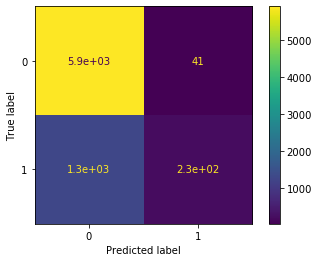

In [216]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(rf, X_train, y_train)

In [217]:
from sklearn.model_selection import GridSearchCV
import math
param_grid = {'max_depth': [4,8,16], 'max_features': [int(math.sqrt(len(X.columns))), int(math.log(len(X.columns)))]}
gs = GridSearchCV(rf, param_grid=param_grid)
gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.8109993222005591
{'max_depth': 16, 'max_features': 7}


0.8084311632870864


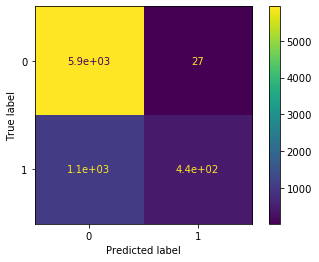

In [219]:
X = dum_reviews.drop('Rating', axis=1)
y = dum_reviews['Rating']

rf = RandomForestClassifier(max_depth=gs.best_params_['max_depth'], max_features=gs.best_params_['max_features'])
rf.fit(X_train, y_train)

print(rf.score(X_test, y_test))
plot_confusion_matrix(rf, X_train, y_train)